# Importing Liberaries

In [1]:
import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('forecast.csv')
# parse strings to datetime type
dataset['Years'] = dataset['Years'].astype(str)
# df = dataset['Years'].apply(lambda x:int(x))
# df

In [3]:
dataset.head()

,Years,production,Area,productivity
0,1970,17990,31094,578.57
1,1971,14558,28547,509.97
2,1972,12752,28614,445.66
3,1973,17509,31528,555.35
4,1974,14046,28072,500.36


In [4]:
dataset.count()

Years           50
production      50
Area            50
productivity    50
dtype: int64

In [5]:
dataset['Years'] = pd.to_datetime(dataset['Years'])
indexedDataset = dataset.set_index(['Years'])


In [6]:
indexedDataset.head()

,production,Area,productivity
Years,,,
1970-01-01,17990,31094,578.57
1971-01-01,14558,28547,509.97
1972-01-01,12752,28614,445.66
1973-01-01,17509,31528,555.35
1974-01-01,14046,28072,500.36


# Data Visualisation

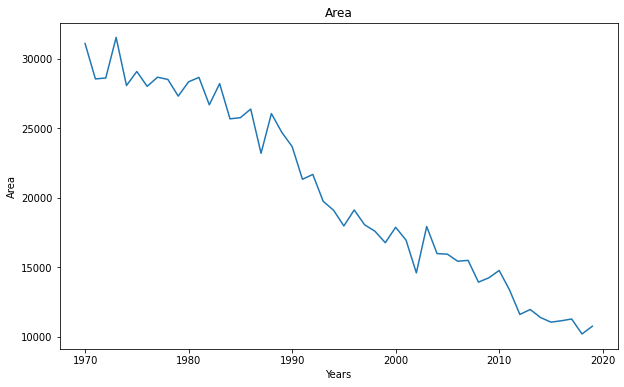

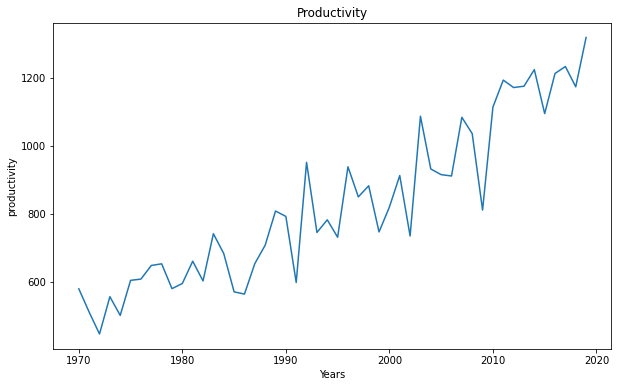

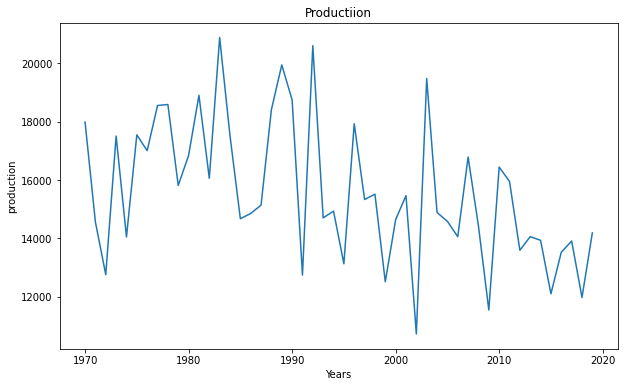

In [7]:
# draw lineplot
sns.lineplot(x="Years", y="Area", data=dataset).set(title='Area')
plt.show()
sns.lineplot(x="Years", y="productivity", data=dataset).set(title='Productivity')
plt.show()
sns.lineplot(x="Years", y="production", data=dataset).set(title='Productiion')
plt.show()

In [8]:
indexedDataset = indexedDataset.drop('production', axis=1)
indexedDataset = indexedDataset.drop('Area', axis=1)

In [9]:
indexedDataset.head()

,productivity
Years,
1970-01-01,578.57
1971-01-01,509.97
1972-01-01,445.66
1973-01-01,555.35
1974-01-01,500.36


# Decomposing Time Series

<Figure size 720x432 with 0 Axes>

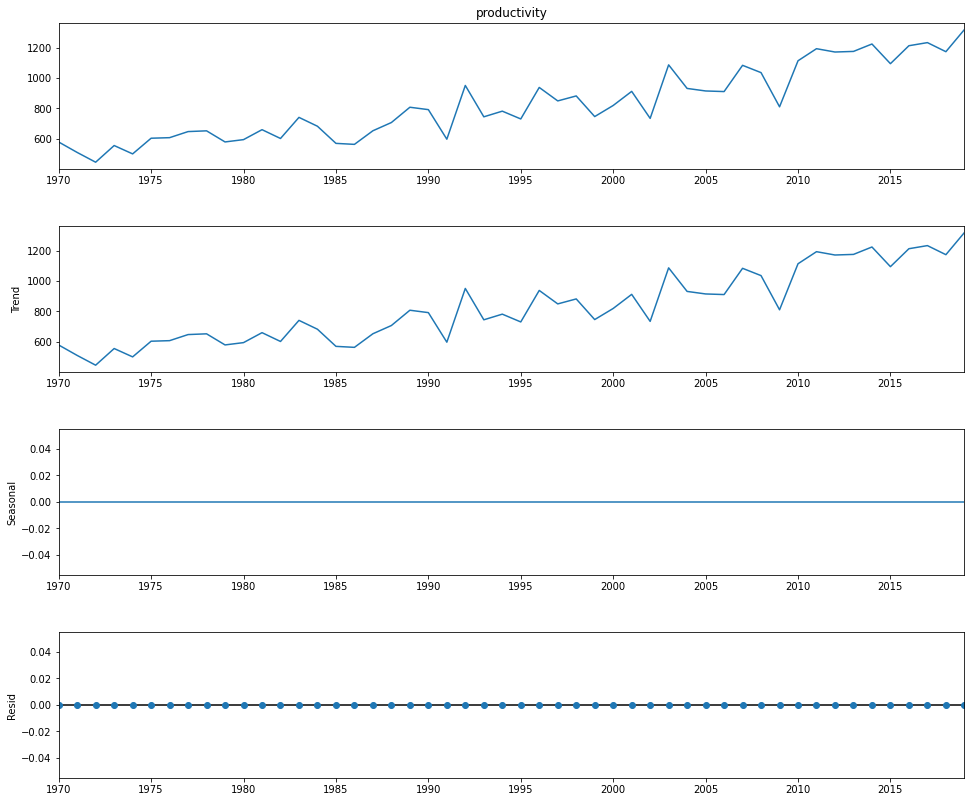

In [10]:
#Seasonal decomposition using moving averages
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(indexedDataset['productivity'], model='additive', period=1)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

# Checking Stationarity

Dickey-Fuller Test
- A stationary time series is one whose properties do not depend on the time at which the series is observed.

In [11]:
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(indexedDataset['productivity'])

p-value = 0.9987. The series is likely non-stationary.
Test Statistic                  2.037009
p-value                         0.998719
#Lags Used                      8.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


## Converting into stationarity

p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.159808e+00
p-value                        2.988483e-10
#Lags Used                     2.000000e+00
Number of Observations Used    4.600000e+01
Critical Value (1%)           -3.581258e+00
Critical Value (5%)           -2.926785e+00
Critical Value (10%)          -2.601541e+00
dtype: float64


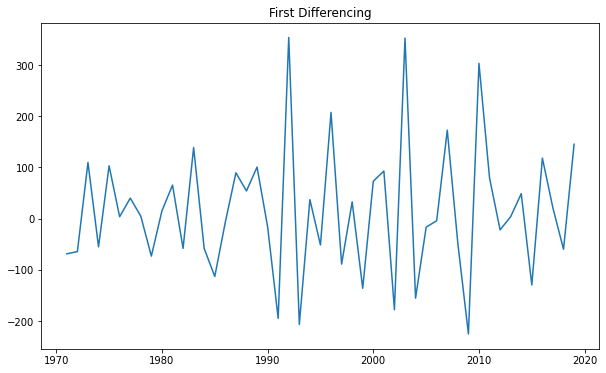

In [45]:
first_diff = indexedDataset.productivity - indexedDataset.productivity.shift(1)
plt.plot(first_diff)
plt.title("First Differencing")
first_diff = first_diff.dropna(inplace = False)
# print(first_diff.head())
dickey_fuller_test(first_diff)

# Data Spliting

In [13]:
size = int(0.80*len(indexedDataset))
train_df = indexedDataset[:size]
test_df  = indexedDataset[size:]
length = len(indexedDataset)
length_train = len(train_df)
length_test = len(test_df)

In [14]:
train_df.count()

productivity    40
dtype: int64

In [15]:
test_df.head()

,productivity
Years,
2010-01-01,1113.33
2011-01-01,1192.79
2012-01-01,1170.92
2013-01-01,1174.86
2014-01-01,1223.63


Text(0.5, 1.0, 'Productivity')

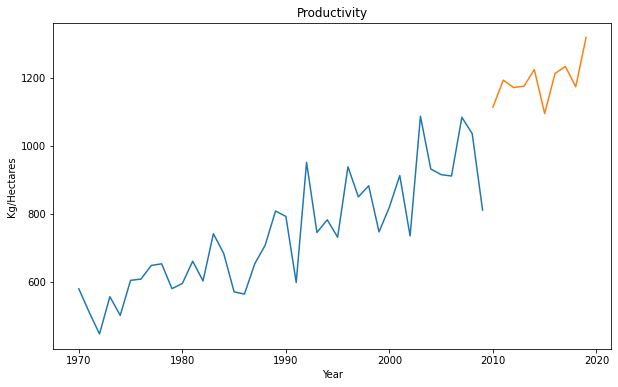

In [46]:
plt.plot(train_df)
plt.plot(test_df)
plt.xlabel('Year')
plt.ylabel('Kg/Hectares')
plt.title("Productivity")

# Ploting ACF and PACF

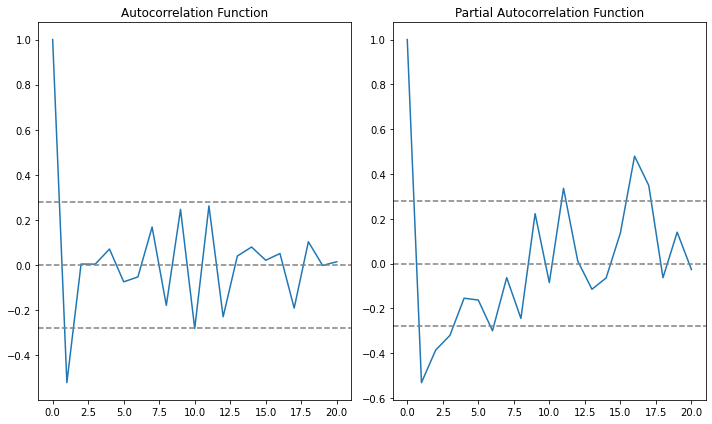

In [17]:
# an only compute partial correlations for lags up to 50% of the sample size. Hence nlag = 40//2 = 20
lag_acf = acf(first_diff,nlags=20)
lag_pacf = pacf(first_diff,nlags=20)

# The axhline() function in pyplot module of matplotlib library is used to add a horizontal line across the axis.

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray') #Formula of CI = 1.96* sqrt(n)
plt.axhline(y=1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

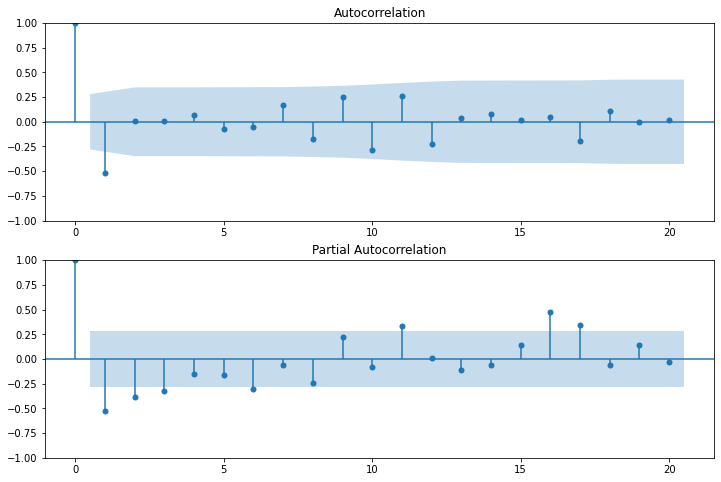

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=20, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=20, ax=ax2)

## Auto Arima for Estimating Parameters

In [19]:
from pmdarima import auto_arima

fit = auto_arima(indexedDataset, trace=True, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, 
                 start_Q=1, max_P=20, max_Q=20, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', 
                 alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True,n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=618.906, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=605.149, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=589.603, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=617.578, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=590.736, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=590.461, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=600.235, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.950 seconds


# ARIMA Model

In [20]:
arima_model = sm.tsa.arima.ARIMA(endog = train_df,order=(0, 1, 1))
ar_model= arima_model.fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           productivity   No. Observations:                   40
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -236.493
Date:                Wed, 23 Nov 2022   AIC                            476.986
Time:                        11:03:34   BIC                            480.313
Sample:                    01-01-1970   HQIC                           478.180
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6749      0.152     -4.450      0.000      -0.972      -0.378
sigma2      1.067e+04   2176.876      4.903      0.000    6407.384    1.49e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.59   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.11   Prob(JB):                         0.64
Heteroskedasticity (H):               3.12   Skew:                             0.36
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The P-Value should be less than 0.05, ideally for the corresponding X to be significant.

## Forecast

In [21]:
start_index = length_train+1
end_index= length
predicted_arima = ar_model.predict(start = start_index, end = end_index)
print(predicted_arima.head())

2011-01-01    931.103989
2012-01-01    931.103989
2013-01-01    931.103989
2014-01-01    931.103989
2015-01-01    931.103989
Freq: AS-JAN, Name: predicted_mean, dtype: float64


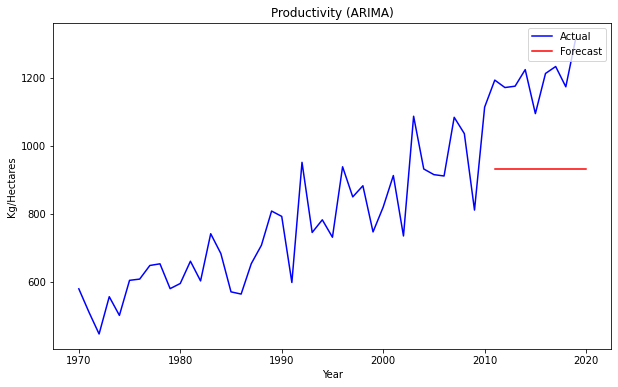

In [48]:
plt.plot(indexedDataset, color="blue", label = "Actual")
plt.plot(predicted_arima,color='red', label = "Forecast")
plt.title("Productivity (ARIMA)")
plt.xlabel('Year')
plt.ylabel('Kg/Hectares')
plt.legend(loc="upper right")

In [23]:
def error(y_true, y_pred):
    mad = np.mean(abs((y_true-y_pred)))
    MSE = np.mean(np.square((y_true-y_pred)))
    RMSE = np.sqrt(MSE)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('MAD: %.2f  \nRMSE: %.2f \nMAPE: %.2f'% (mad,RMSE,MAPE))

In [24]:
error(test_df["productivity"],predicted_arima)

MAD: 268.10  
RMSE: 274.09 
MAPE: 22.18


In [25]:
print(predicted_arima.head())

2011-01-01    931.103989
2012-01-01    931.103989
2013-01-01    931.103989
2014-01-01    931.103989
2015-01-01    931.103989
Freq: AS-JAN, Name: predicted_mean, dtype: float64


## SARIMA MODEL

In [26]:
sarima_model = sm.tsa.statespace.SARIMAX(train_df, trend='t', order=(0,1,1)).fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:           productivity   No. Observations:                   40
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -232.810
Date:                Wed, 23 Nov 2022   AIC                            471.620
Time:                        11:03:35   BIC                            476.611
Sample:                    01-01-1970   HQIC                           473.410
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.5724      0.121      4.721      0.000       0.335       0.810
ma.L1         -0.9998     41.519     -0.024      0.981     -82.376      80.376
sigma2      8158.2981   3.38e+05      0.024      0.9

In [52]:
start_index = length_train
end_index = length+10
predicted_sarima = sarima_model.predict(start = start_index, end= end_index, typ="labels") 
print(predicted_sarima.head())

2010-01-01    1054.324947
2011-01-01    1077.793402
2012-01-01    1101.834258
2013-01-01    1126.447516
2014-01-01    1151.633175
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [53]:
# predicted_sarima.to_excel('predicted_prod.xlsx')

In [54]:
error(test_df["productivity"],predicted_sarima)

MAD: 57.46  
RMSE: 66.54 
MAPE: 4.90


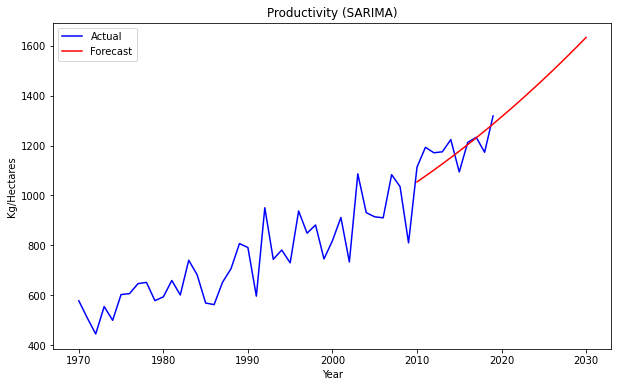

In [55]:
plt.plot(indexedDataset, color="blue", label = "Actual")
plt.plot(predicted_sarima,color='red', label = "Forecast")
plt.title("Productivity (SARIMA)")
plt.xlabel('Year')
plt.ylabel('Kg/Hectares')
plt.legend(loc="upper left")

## Simple Exponential Smoothing (SES)

In [36]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
start_index = 1
end_index = length+10
predicted_ses = SimpleExpSmoothing(indexedDataset['productivity']).fit().predict(start = start_index, end= end_index)

In [37]:
error(indexedDataset["productivity"],predicted_ses)

MAD: 83.62  
RMSE: 105.58 
MAPE: 10.17


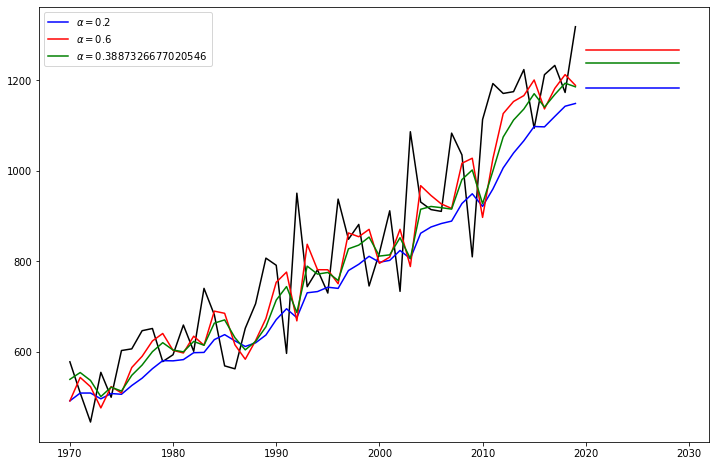

In [44]:
fit1 = SimpleExpSmoothing(indexedDataset['productivity'], initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(10).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(indexedDataset['productivity'], initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(10).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(indexedDataset['productivity'], initialization_method="estimated").fit()
fcast3 = fit3.forecast(10).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(12, 8))
plt.plot(indexedDataset['productivity'], color="black")
plt.plot(fit1.fittedvalues,  color="blue")
(line1,) = plt.plot(fcast1, color="blue")
plt.plot(fit2.fittedvalues,  color="red")
(line2,) = plt.plot(fcast2,  color="red")
plt.plot(fit3.fittedvalues,  color="green")
(line3,) = plt.plot(fcast3,  color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])